In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:00


In [ ]:
import os

home = '/content/drive/MyDrive/2ReadyForFineTuning/MuMuQA/'

imroot = home+'mumuQA_images'
os.chdir(home)

In [ ]:
prefix = 'mumuqa'

In [ ]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "mumuqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.json') as f:
  data = json.load(f)
  print(len(data))
  global datalen
  datalen = len(data)
  print(datalen)
  for i in data[0:int(datalen*0.8)]:
    imlist = i['images']
    anslist = [str(i) for i in i['answer_choices']]
    try:
      assert len(anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+imlist.lstrip('./images/'), "question": i['question']+" "+i['passage'], "question_id": i['qid'], "answer_choices": anslist, "answer_id": int(i['answer']) } )

with open('/content/'+prefix+'_train.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

#print(dumpdict)

5285
5285


In [ ]:
import json
f = open('/content/'+prefix+'_train.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 4228


In [ ]:
questions[0]

{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/MuMuQA/mumuQA_images/459585D-D9DF-4CF3-B7C9-38A2C3267B1D.jpg.png',
 'question': 'when did person in the image of south africa go into hospital Nelson Mandela wrote about feeling, upon his release from prison, that he had failed to be there for his own children and grandchildren. Instead, he wrote, his decades-long struggle against apartheid had turned him into the father of his nation.\nFormer South African President Nelson Mandela as he celebrates his birthday with family in Qunu, South Africa, July 18, 2012.\nThat became clear this weekend as news of his Saturday hospitalization spread and the Internet buzzed with virtual get-well cards from luminaries, journalists and ordinary South Africans.\nMandela spent Saturday night in the hospital and appeared “comfortable and in good care” on Sunday morning, said President Jacob Zuma.\n Former South African President Nelson Mandela as he celebrates his birthday with family in Qunu, Sou

In [ ]:
from os import listdir
from os.path import isfile, join

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['EABEBFD-9B51-415F-B194-043C96ED1C8D.png.png', 'B1923A6-81F2-4DDB-8993-E7CD7BC850AD.jpg.png', 'F53E032-51CE-48F8-B409-1EDA585D4FF3.jpg.png', '8DD1253-A955-40D5-8B72-3A8F64A250B4.jpg.png', 'DA4734F-A562-456C-B05B-314CFCBAEF1F.jpg.png', 'BEC6100-30FB-431D-95E3-BE3456BDA124.jpg.png', '2EF5357-34AF-4A43-A9FF-B13171F6B6DB.jpg.png', 'DA6DDF8-300C-4F5B-88C6-AA3B19AA3685.jpg.png', 'E86FFCA-A380-4CD6-8018-DC2847A8CB60.jpg.png', '9C36E93-D096-416A-A123-70AD9B1B501D.jpg.png', 'C8EFBC5-7F96-46A7-8908-55EC386B65BF.jpg.png', '5C4BEF1-DCBF-4EF5-B792-79DBD85437C1.jpg.png', '9DA671C-360A-4737-AEC1-05024588DDB6.jpg.png', '1A52715-E031-411B-8D34-B878E6470184.jpg.png', '1E86FB6-D3F5-4C52-B57B-BB27218E5D99.jpg.png', '932518D-464C-4C4F-A285-27AE84A32008.jpg.png', '526E99B-281E-48D8-A87B-79AE4CE1B217.jpg.png', 'F549396-CEFF-4FDA-A05C-4C6AD7E5EF8F.jpg.png', 'DAF2408-9067-4187-B0A9-A983285498DF.jpg.png', 'A69EE04-3565-42F4-9ACA-046640658B08.jpg.png', '7A10FC9-23F5-4CC3-A914-B3EFAAC5374B.jpg.png', 'DE7EE12-ED5

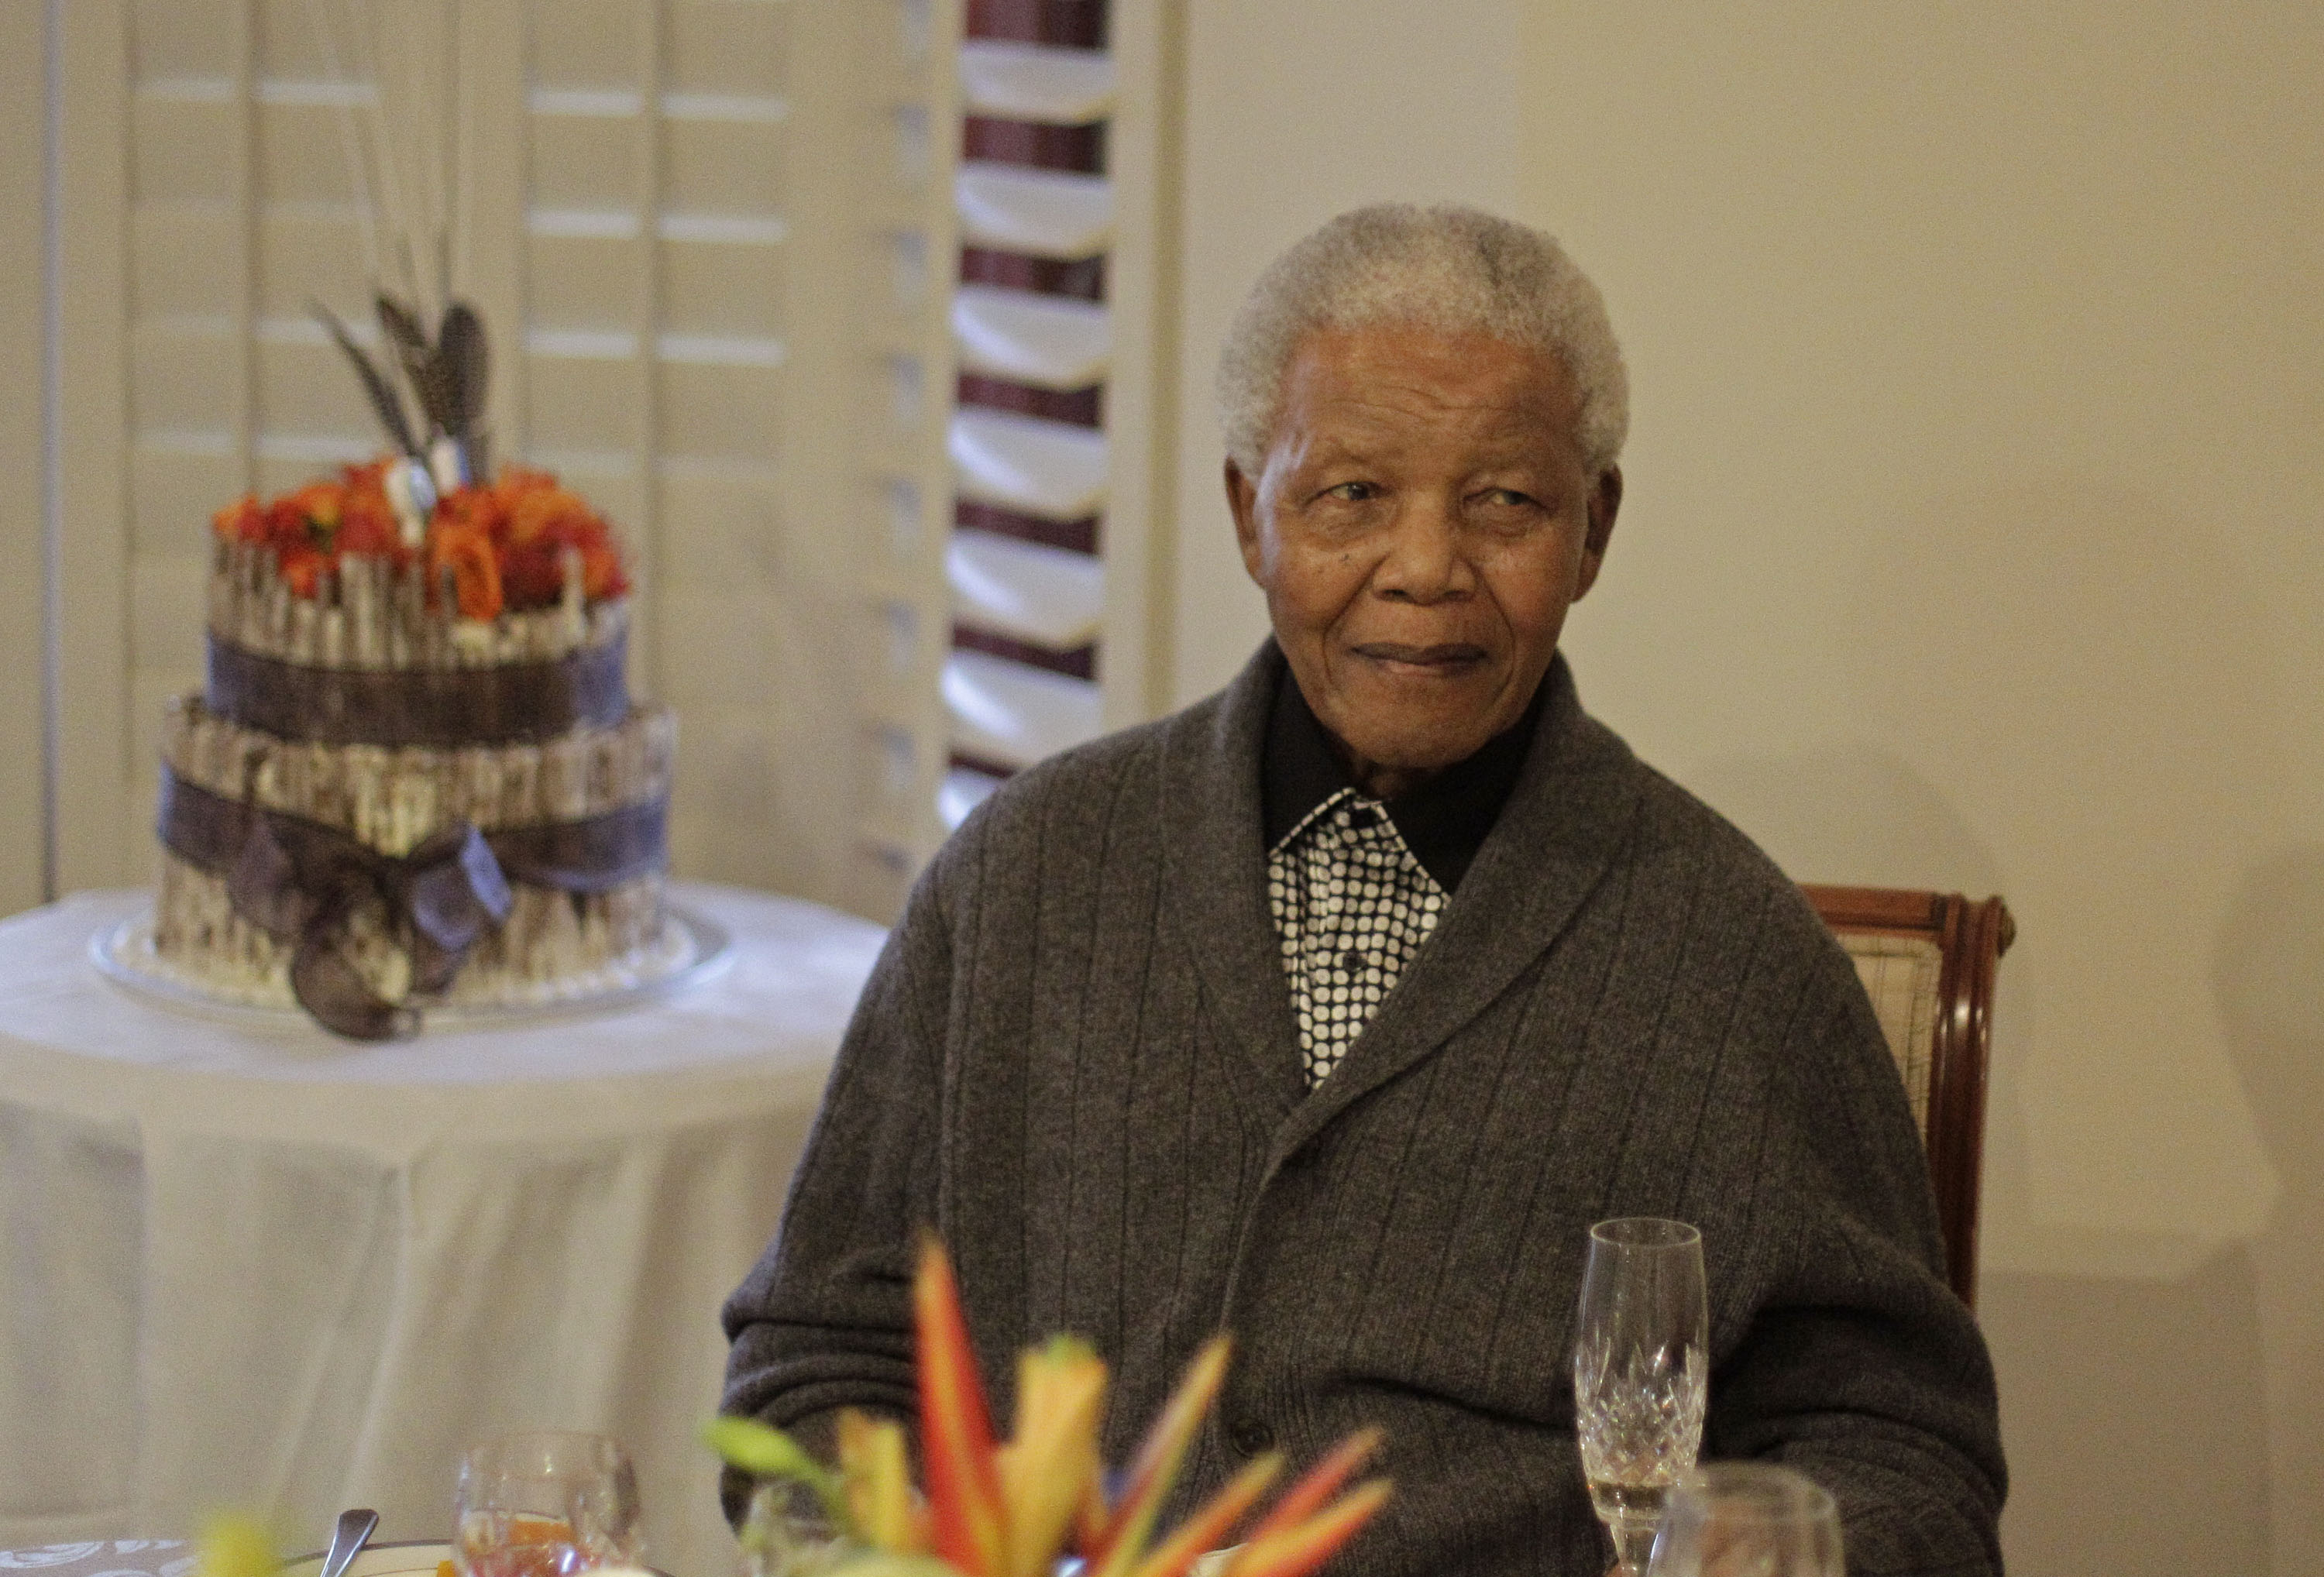

In [ ]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [ ]:
import torch
import torchvision
from PIL import Image
import torch.nn.functional as F
from torch import ones, long as lg, float as fl
import torchvision.transforms as transforms

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor):
        self.questions = questions
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        questions = self.questions[idx]
        image = Image.open(questions['image_id']).convert("RGB")
        resize_transform = transforms.Resize((384, 384))
        image = resize_transform(image)
        text = questions['question']
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")

        encoding['visual_embeds'] = encoding['pixel_values']
        encoding['visual_embeds'] = encoding['visual_embeds'][:,0,:,:]
        encoding.pop('pixel_values')
        encoding.pop('pixel_mask')
        encoding['visual_token_type_ids'] = ones(encoding['visual_embeds'].shape[:-1], dtype=lg)
        encoding['visual_attention_mask'] = ones(encoding['visual_embeds'].shape[:-1], dtype=fl)

        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        encoding["labels"] = targets
        return encoding

In [ ]:
from transformers import ViltProcessor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset = VQADataset(questions=questions,processor=processor)

In [ ]:
dataset[0]

{'input_ids': tensor([  101,  2043,  2106,  2711,  1999,  1996,  3746,  1997,  2148,  3088,
         2175,  2046,  2902,  5912, 26887,  2626,  2055,  3110,  1010,  2588,
         2010,  2713,  2013,  3827,  1010,  2008,  2002,  2018,  3478,  2000,
         2022,  2045,  2005,  2010,  2219,  2336,  1998, 13628,  1012,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'pixel_values': tensor([[[ 0.1608,  0.1765,  0.1843,  ...,  0.2784,  0.2941,  0.2784],
         [ 0.1686,  0.1843,  0.1608,  ...,  0.2706,  0.2706,  0.2627],
         [ 0.1608,  0.1765,  0.1843,  ...,  0.2549,  0.2706,  0.2627],
         ...,
         [ 0.3333,  0.3569,  0.3725,  ..., -0.0118, -0.0118, -0.0196],
         [ 0.1922,  0.2000,  0.1922,  ..., -0.

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
len(dataset)

4228

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] when did person in the image of south africa go into hospital nelson mandela wrote about feeling, upon his release from prison, that he had failed to be there for his own children and grandchildren. [SEP]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
labels

3

In [ ]:
from transformers import VisualBertForQuestionAnswering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisualBertForQuestionAnswering.from_pretrained("daki97/visualbert_finetuned_easy_vqa", num_labels=4,ignore_mismatched_sizes=True, visual_embedding_dim = 384)
model.to(device)

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import ones, long as lg, float as fl,  stack, FloatTensor

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  visual_embeds = [item['visual_embeds'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  visual_token_type_ids = [item['visual_token_type_ids'] for item in batch]
  visual_attention_mask = [item['visual_attention_mask'] for item in batch]
  labels = [item['labels'] for item in batch]

  batch = {}
  batch['visual_embeds'] = torch.stack(visual_embeds)
  batch['input_ids'] = torch.stack(input_ids)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['visual_token_type_ids'] = torch.stack(visual_token_type_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['visual_attention_mask'] = torch.stack(visual_attention_mask)
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 384, 480])
pixel_mask torch.Size([1, 384, 480])
labels torch.Size([1, 4])


## Start Training

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/4228 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/4228 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/4228 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/4228 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/4228 [00:00<?, ?it/s]

## Inference

In [ ]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "mumuqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.json') as f:
  data = json.load(f)
  print(len(data))
  global datalen
  datalen = len(data)
  print(datalen)
  for i in data[int(datalen*0.8):datalen]:
    test_imlist = i['images']
    test_anslist = [str(i) for i in i['answer_choices']]
    try:
      assert len(test_anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+test_imlist.lstrip('./images/'), "question": i['question']+" "+i['passage'], "question_id": i['qid'], "answer_choices": test_anslist, "answer_id": int(i['answer']) } )

with open('/content/'+prefix+'_test.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

#print(dumpdict)

5285
5285


In [ ]:
import json
f = open('/content/'+prefix+'_test.jsonl','r')
test_data_questions = json.load(f)
test_questions = test_data_questions['questions']

print(test_data_questions.keys())
print("Number of questions:", len(test_questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 1057


In [ ]:
test_dataset = VQADataset(questions=test_questions,processor=processor)

In [ ]:
len(test_dataset)

1057

# Single Instance Inference

In [ ]:
exid = 1
example = test_dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", test_dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 1
Ground-truth answer: 3


# Batch Inference

In [ ]:
import csv
filprefix = prefix+"_result"

count = 0
st = 0
end = datalen-int(datalen*0.8)
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = test_dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = test_dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])